In [2]:
from transformers import CLIPProcessor, CLIPModel
import torch
import matplotlib.pyplot as plt
import io
from PIL import Image
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode
from sache import SpecifiedHookedViT

In [3]:
def print_stats(tensor):
    if tensor.dtype is not torch.float32:
        print('cannot print stats for non-float32 tensor')
    else:
        print('mean', round(tensor.mean().item(), 4), 'std', round(tensor.std().item(), 4), 'min', round(tensor.min().item(), 4), 'max', round(tensor.max().item(), 4))

In [4]:
model_name ='laion/CLIP-ViT-L-14-laion2B-s32B-b82K'
processor = CLIPProcessor.from_pretrained(model_name)
transform = transforms.ToTensor()

In [5]:
hook_locations = [
    (2, 'resid'),
    (20, 'resid'),
]
transformer = SpecifiedHookedViT(hook_locations, model_name, device='cuda')

In [6]:
with open('cruft/img.jpeg', 'rb') as f:
    image = Image.open(io.BytesIO(f.read())).convert('RGB')
    it1 = transform(image)

it2 = read_image('cruft/img.jpeg', mode=ImageReadMode.RGB)

it3 = read_image('cruft/mouse.jpg', mode=ImageReadMode.RGB)

print('Image.open')
print_stats(it1)
print('read_img')
print_stats(it2)
print('mouse read_img')
print_stats(it3)

Image.open
mean 0.5212 std 0.1773 min 0.0 max 0.851
read_img
cannot print stats for non-float32 tensor
mouse read_img
cannot print stats for non-float32 tensor


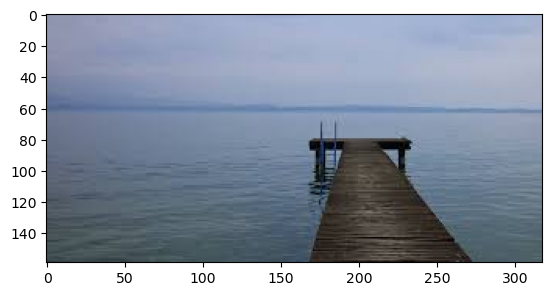

In [7]:
plt.imshow(it1.permute(1, 2, 0))

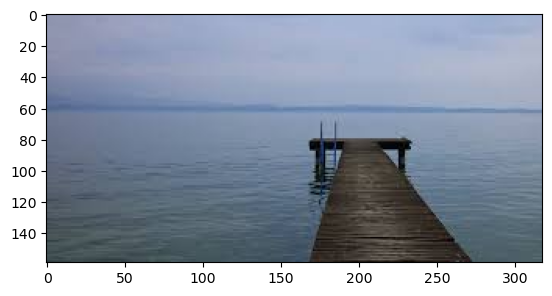

In [8]:
plt.imshow(it2.permute(1, 2, 0))

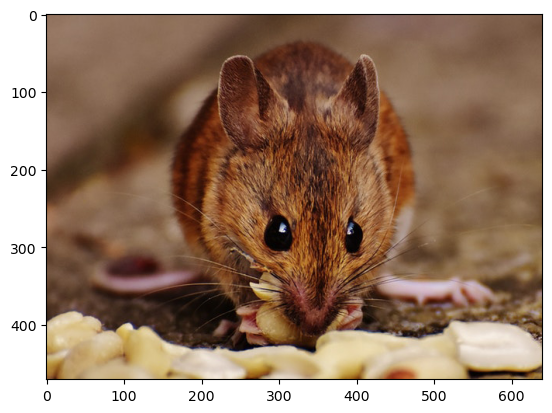

In [9]:
plt.imshow(it3.permute(1, 2, 0))

In [10]:
q  = processor(images=it1, text = "", return_tensors="pt", padding = True)
print('Image.open')
print_stats(q['pixel_values'])

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Image.open
mean -0.996 std 0.0015 min -1.0 max -0.9934


In [11]:
q  = processor(images=it2, text = "", return_tensors="pt", padding = True)
print('read_image')
print_stats(q['pixel_values'])

read_image
mean 0.0253 std 0.3914 min -1.0 max 0.6863


In [12]:
q  = processor(images=it3, text = "", return_tensors="pt", padding = True)
print('mouse read_image')
print_stats(q['pixel_values'])

mouse read_image
mean -0.2513 std 0.4147 min -1.0 max 0.9294


In [13]:
o1 = transformer.all_activations(it1.unsqueeze(0).cuda())
o2 = transformer.all_activations(it2.unsqueeze(0).cuda())
o3 = transformer.all_activations(it3.unsqueeze(0).cuda())


Image.open
mean 0.0488 std 0.1851 min -2.4081 max 1.9263
read_image
mean 0.1154 std 0.2346 min -2.2912 max 2.3887
mouse read_image
mean 0.1333 std 0.2367 min -2.6984 max 2.0335
imag.open and read_image 0.555884838104248
mouse and dock read_image 0.37420564889907837


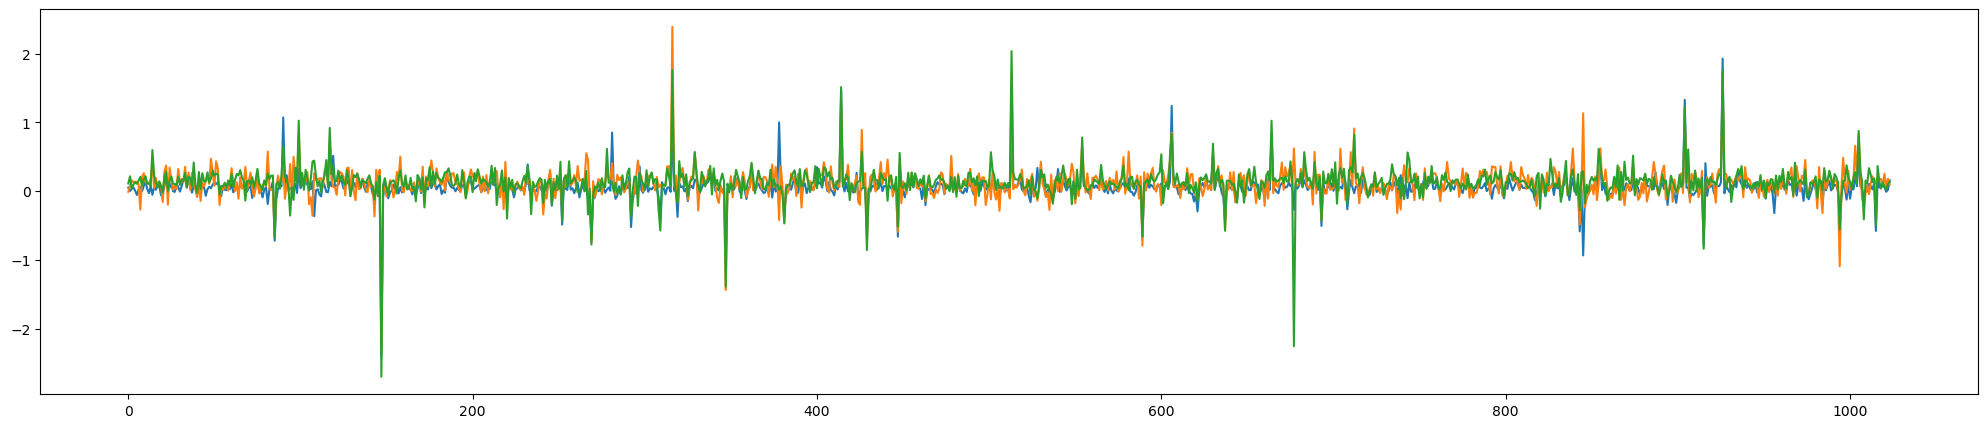

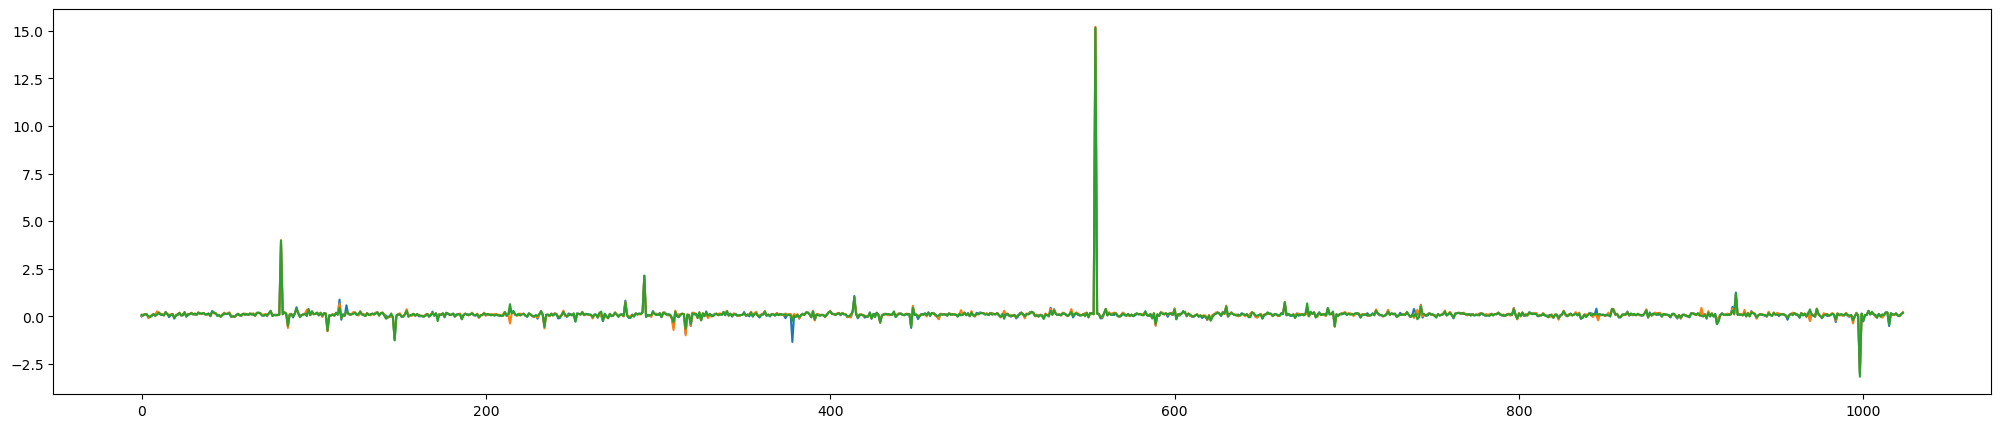

In [14]:
location = (2, 'resid')
print('Image.open')
print_stats(o1[location][0, 1])
print('read_image')
print_stats(o2[location][0, 1])
print('mouse read_image')
print_stats(o3[location][0, 1])

cos = torch.nn.functional.cosine_similarity(o1[location], o2[location], dim=-1)
print('imag.open and read_image', cos.mean().item())
cos = torch.nn.functional.cosine_similarity(o2[location], o3[location], dim=-1)
print('mouse and dock read_image', cos.mean().item())

plt.figure(figsize=(25, 5))

plt.plot(o1[location][0, 1].cpu().detach().numpy())
plt.plot(o2[location][0, 1].cpu().detach().numpy())
plt.plot(o3[location][0, 1].cpu().detach().numpy())


plt.show()


plt.figure(figsize=(25, 5))

plt.plot(o1[location][0, 0].cpu().detach().numpy())
plt.plot(o2[location][0, 0].cpu().detach().numpy())
plt.plot(o3[location][0, 0].cpu().detach().numpy())


plt.show()

# show cosine similarity between o1[location] and o2[location]




Image.open
mean 0.1352 std 0.4144 min -1.7887 max 2.362
read_image
mean 0.1958 std 0.5486 min -8.0049 max 3.5242
mouse read_image
mean 0.2147 std 0.6345 min -5.3257 max 8.9155
imag.open and read_image 0.36705198884010315
mouse and dock read_image 0.24804382026195526


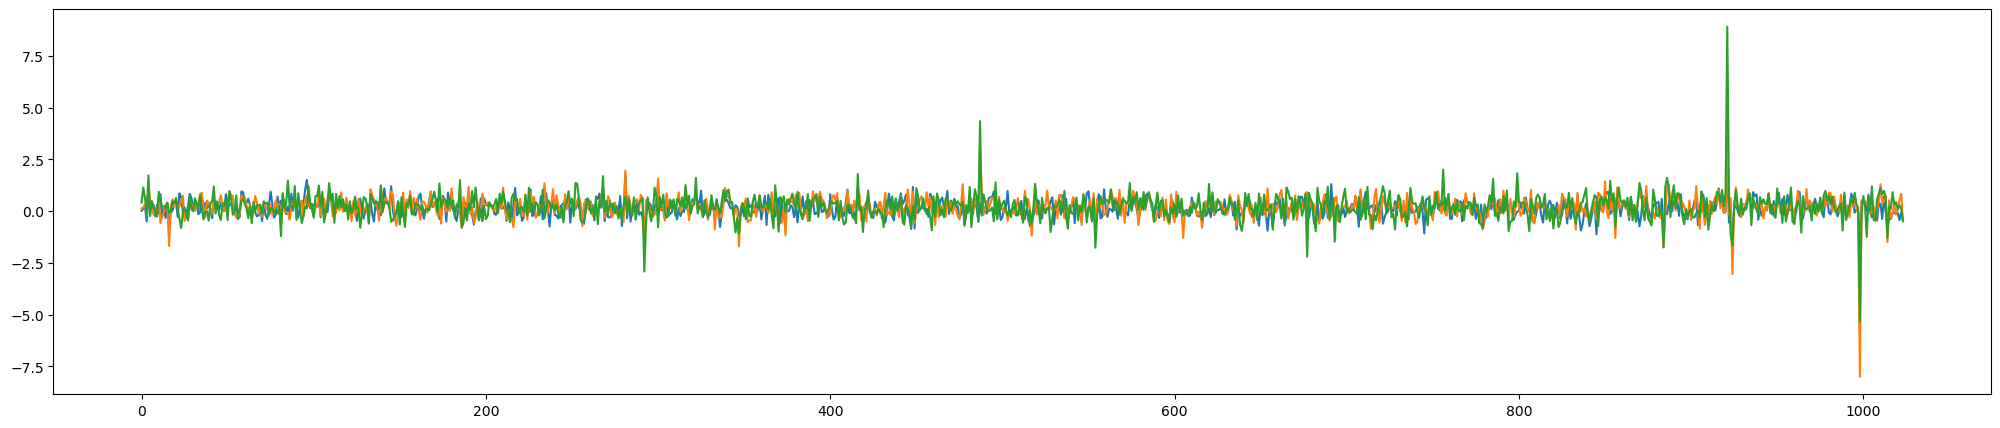

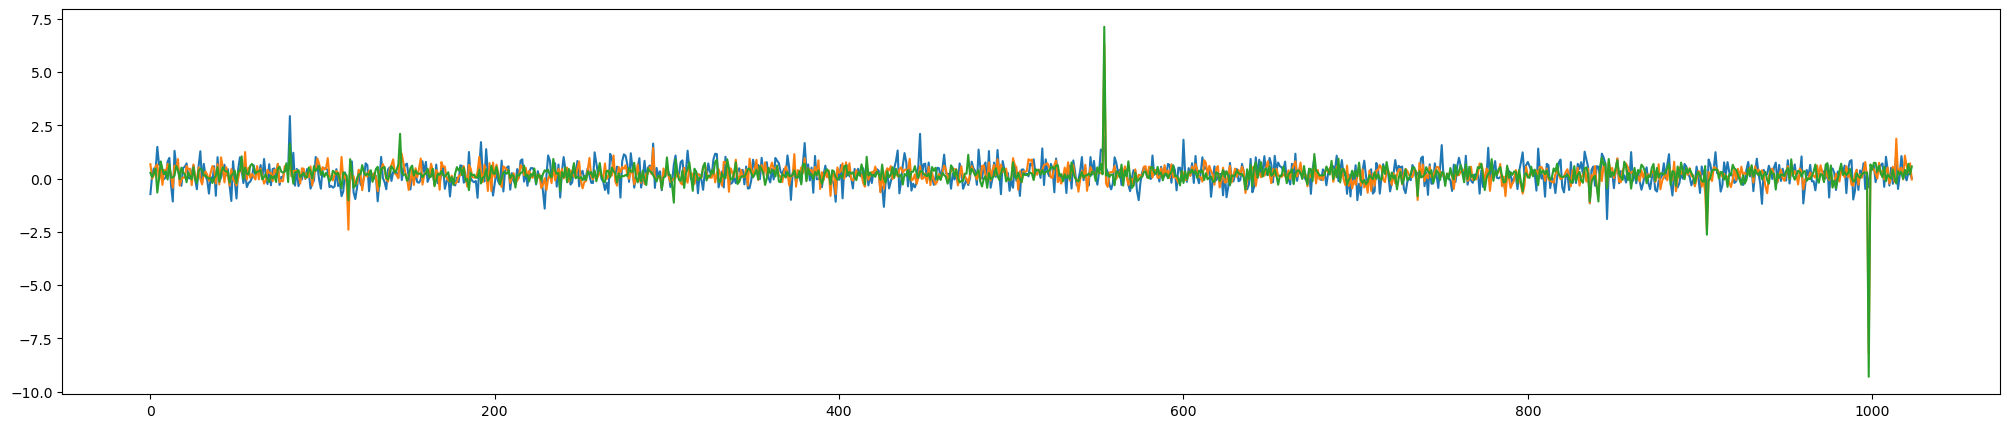

In [15]:
location = (20, 'resid')
print('Image.open')
print_stats(o1[location][0, 1])
print('read_image')
print_stats(o2[location][0, 1])
print('mouse read_image')
print_stats(o3[location][0, 1])

cos = torch.nn.functional.cosine_similarity(o1[location], o2[location], dim=-1)
print('imag.open and read_image', cos.mean().item())
cos = torch.nn.functional.cosine_similarity(o2[location], o3[location], dim=-1)
print('mouse and dock read_image', cos.mean().item())

plt.figure(figsize=(25, 5))

plt.plot(o1[location][0, 1].cpu().detach().numpy())
plt.plot(o2[location][0, 1].cpu().detach().numpy())
plt.plot(o3[location][0, 1].cpu().detach().numpy())


plt.show()


plt.figure(figsize=(25, 5))

plt.plot(o1[location][0, 0].cpu().detach().numpy())
plt.plot(o2[location][0, 0].cpu().detach().numpy())
plt.plot(o3[location][0, 0].cpu().detach().numpy())


plt.show()

# show cosine similarity between o1[location] and o2[location]




In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import torch

In [3]:
files = [
    '../vitact/cruft/2_resid_29c579.jsonl',
    '../vitact/cruft/20_resid_5998fd.jsonl',
]
infos = []
for file in files:
    rows = []
    with open(file) as f:
        lines = f.readlines()
        for l in lines:
            rows.append(json.loads(l))


    info = defaultdict(list)
    info['name'] = file

    for row in rows:
            for k in ['mbps', 'enc', 'dec', 'enc_b', 'dec_b', 'delta_hist', 'input_hist', 'reconstruction_hist', 'current_k',
                    'latent_hist', 'rmse', 'mse', 'sum_mse', 'scaled_mse', 'input_mean', 'input_std', 'L0', 'L1', 'loss', 'dead_feature_prop', 'dead_latent_pct',
                    'experts_chosen_hist', 'enc_hist', 'dec_hist', 
                    'enc_grad_hist', 'dec_grad_hist', 'router_grad_hist', 'pre_grad_hist',
                    'pos_mask',
                    'position_mse', 'ma_count', 'massive_activations'
                    
                    ]:
                if k in row:
                    info[k].append(row[k])


    infos.append(info)

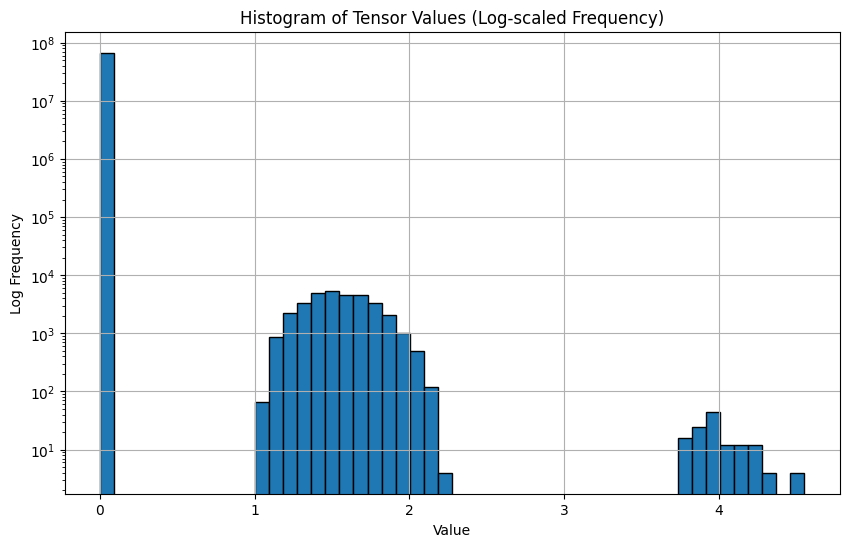

67119064.0
67115672.0
67115216.0
67115179.0
67115075.0
67115271.0
67115435.0
67115554.0
67115350.0
67115484.0


In [48]:
i = 101
info = infos[0]
h = info['latent_hist']
hist = np.array(h[i]['counts'])
edges = np.array(h[i]['edges'])

plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(edges[:-1], hist, width=np.diff(edges), edgecolor='black', align='edge')  # Plot histogram
plt.grid()
# Apply a logarithmic scale to exaggerate lower frequencies and downplay higher ones
plt.yscale('log')

# Labeling the axes
plt.xlabel('Value')
plt.ylabel('Log Frequency')  # Indicate that y-axis is log-scaled
plt.title('Histogram of Tensor Values (Log-scaled Frequency)')

# Show the plot
plt.show()

for i in range(0, 5000, 500):
    print(sum(h[i]['counts']))

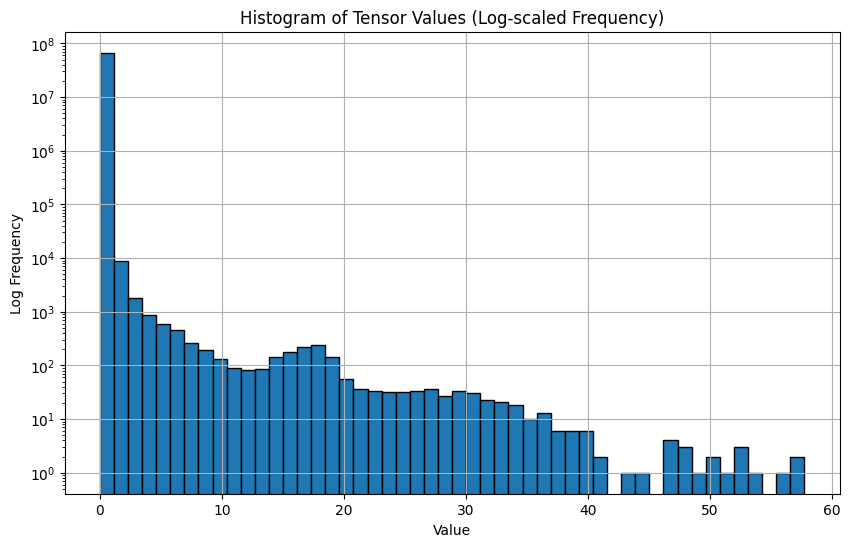

67117072.0


In [37]:
i = 4000
info = infos[1]
h = info['latent_hist']
hist = np.array(h[i]['counts'])
edges = np.array(h[i]['edges'])

plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(edges[:-1], hist, width=np.diff(edges), edgecolor='black', align='edge')  # Plot histogram

# Apply a logarithmic scale to exaggerate lower frequencies and downplay higher ones
plt.yscale('log')
plt.grid()
# Labeling the axes
plt.xlabel('Value')
plt.ylabel('Log Frequency')  # Indicate that y-axis is log-scaled
plt.title('Histogram of Tensor Values (Log-scaled Frequency)')

# Show the plot
plt.show()

print(sum(h[i]['counts']))


In [39]:
for i in range(0, 5000, 500):
    print(sum(h[i]['counts']))

67123460.0
67120443.0
67118349.0
67116162.0
67116619.0
67115192.0
67117337.0
67117799.0
67117072.0
67114609.0


In [51]:
a = torch.rand(65536, 1024)

bins=50
counts = torch.histc(a, bins=bins, min=float(a.min()), max=float(a.max()))


print(counts.shape, counts.sum())

torch.Size([50]) tensor(67108864.)
